# Weibo

## Loading

In [1]:
import pickle
import json
import random
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import torch

sns.set()
%matplotlib inline

In [2]:
def print_in_color(s, cint=31, end='\n'):
    print('\x1b[{}m{}\x1b[0m'.format(cint, s), end=end)

In [3]:
with open('../../dataset/Weibo/raw/FN_11934_filtered.json', 'r') as f:
    FN = json.load(f)

with open('../../dataset/Weibo/raw/DN_27505_filtered.json', 'r') as f:
    DN = json.load(f)

fnOid2item = {fn['_id']: fn for fn in FN}
dnOid2item = {dn['_id']: dn for dn in DN}

fnIdx2item = {i: fn for i, fn in enumerate(FN)}
dnIdx2item = {i: dn for i, dn in enumerate(DN)}

fnOid2idx = {fn['_id']: i for i, fn in enumerate(FN)}
dnOid2idx = {dn['_id']: i for i, dn in enumerate(DN)}

len(FN), len(DN)

(11934, 27505)

In [4]:
fn_embeddings = torch.load(
    '../ROT/data/Weibo/FN_bert-base-chinese_embeddings_static.pt')
dn_embeddings = torch.load(
    '../ROT/data/Weibo/DN_bert-base-chinese_embeddings_static.pt')

len(fn_embeddings), len(dn_embeddings)

(11934, 27505)

In [5]:
def pytorch_euclidean_distance(a, b):
    return torch.dist(a, b)


def get_sim_scores(fn_emb, dn_emb):
    score_dict = dict()

    for qidx, fn in enumerate(tqdm(FN)):
        dn_oids = fn['debunking_ids']

        for did in dn_oids:
            dn = dnOid2item[did]
            didx = dnOid2idx[did]

            query = fn_emb[qidx]
            sentences = dn_emb[didx]

            items = [pytorch_euclidean_distance(
                query, sent).item() for sent in sentences]

#             # Scale
#             m, M = min(items), max(items)
#             items = [1 - (x - m) / (M - m + 1e-8) for x in items]

            if qidx not in score_dict.keys():
                score_dict[qidx] = {didx: items}
            else:
                score_dict[qidx][didx] = items

    return score_dict

In [6]:
distances_dict = get_sim_scores(fn_embeddings, dn_embeddings)

100%|██████████| 11934/11934 [00:12<00:00, 978.34it/s] 


In [7]:
distances_dict[0]

{19: [0.240827739238739,
  0.16636838018894196,
  0.6203256845474243,
  0.22376954555511475,
  0.2720167636871338,
  0.15347903966903687,
  0.4483548402786255,
  0.3415389955043793,
  0.1948276162147522,
  0.20255406200885773,
  0.2571829855442047,
  0.46945202350616455,
  0.3041685223579407,
  0.2650800049304962,
  0.23779737949371338,
  0.25236794352531433,
  0.23080341517925262,
  0.2179158478975296,
  0.2818111181259155,
  0.3188406825065613,
  0.12962418794631958,
  0.22912277281284332,
  0.36622461676597595,
  0.23502960801124573,
  0.3152892589569092]}

## Select the quantiles

In [8]:
total_dist = [z for x in distances_dict.values() for y in x.values()
              for z in y]
len(total_dist)

1260751

In [9]:
total_dist[:20]

[0.240827739238739,
 0.16636838018894196,
 0.6203256845474243,
 0.22376954555511475,
 0.2720167636871338,
 0.15347903966903687,
 0.4483548402786255,
 0.3415389955043793,
 0.1948276162147522,
 0.20255406200885773,
 0.2571829855442047,
 0.46945202350616455,
 0.3041685223579407,
 0.2650800049304962,
 0.23779737949371338,
 0.25236794352531433,
 0.23080341517925262,
 0.2179158478975296,
 0.2818111181259155,
 0.3188406825065613]

In [10]:
df = pd.DataFrame({'dist':total_dist})
len(df)

1260751

In [11]:
df.describe()

,dist
count,1.260751e+06
mean,4.089866e-01
std,2.077371e-01
min,0.000000e+00
25%,2.965157e-01
50%,3.565959e-01
75%,4.399680e-01
max,2.020064e+00


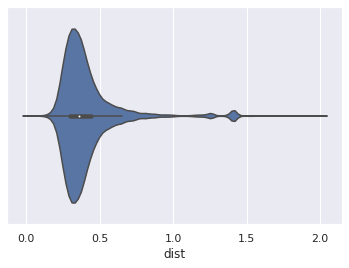

In [12]:
sns.violinplot(data=df, x='dist')

In [13]:
def analysis_ts(ts_1, ts_2):
    num = len(df[(df['dist'] > ts_1) & (df['dist'] < ts_2)])
    print('{:.3f} < chosen_dist < {:.3f}, sample = {:.3%}'.format(
        ts_1, ts_2, num/len(df)))
    print('*'*20, '\n')

    TOP = 5
    qidx = random.randint(0, len(FN) - 1)
    fn = FN[qidx]

    print('[Fake News]\n{}'.format(fn['content_all']))

    for did in fn['debunking_ids']:
        didx = dnOid2idx[did]
        dn = DN[didx]
        
        items = distances_dict[qidx][didx]
        dist_small = sorted(items)[:TOP]

        print('\n---------------------------------------------')
        print('qidx = {}, didx = {}\n'.format(qidx, didx))

        print('[Debunking News]')
        for j, sent in enumerate(dn['content_all']):
            print('[Sent-{}]['.format(j), end='')

            print_func = print_in_color if items[j] in dist_small else print
            print_func('dist: {:.3f}'.format(items[j]), end='')

            print(']\t', end='')

            if items[j] > ts_1 and items[j] < ts_2:
                print_in_color(sent, cint=32)
            else:
                print(sent)

In [14]:
ts_1 = df.describe()['dist']['25%']
ts_2 = df.describe()['dist']['50%']

num = len(df[(df['dist'] > ts_1) & (df['dist'] < ts_2)])
print('{:.3f} < chosen_dist < {:.3f}, sample = {:.3%}'.format(
    ts_1, ts_2, num/len(df)))

0.297 < chosen_dist < 0.357, sample = 25.000%


In [15]:
analysis_ts(ts_1, ts_2)

0.297 < chosen_dist < 0.357, sample = 25.000%
******************** 

[Fake News]
#厦门BRT爆炸后遗症续#成都今天一辆公交车被人喊了句冒烟了，居然有十几个只带小锤的人掏出锤把玻璃仗的稀烂，全部跳车跑了。

---------------------------------------------
qidx = 1724, didx = 12355

[Debunking News]
[Sent-0][dist: 0.208]	#厦门BRT爆炸后遗症续# 今日.据说成都公交车有人喊冒烟了,结果就成了这个样子.你今天带锤子吗?
[Sent-1][dist: 0.505]	 @阮是俊杰 @嘉庚门徒 @张抖抖不爱斗 @厦门琦琦 @红薯马甲 ?
[Sent-2][dist: 1.424]	??
[Sent-3][dist: 1.424]	?
[Sent-4][dist: 0.173]	经查，此微博称“成都今天一辆八路车被人喊了句冒烟了，居然有十多个自带小锤的人掏出锤锤把玻璃仗的稀烂”，并附上一张图片，但此图实为2008年“成都公交行驶中突然冒烟 市民互助逃生”中的新闻配图，详情：。
[Sent-5][dist: 0.400]	被举报人言论属于“图文不符”，构成“发布不实信息”。


## Export clustering data from training set

In [16]:
TS_SMALL = ts_1
TS_LARGE = ts_2

TS_SMALL, TS_LARGE

(0.29651573300361633, 0.35659587383270264)

In [17]:
train_df = pd.read_csv('../../dataset/Weibo/splits/data/top50.train.line',
                       sep='\t', names=["qid", "qidx", "did", "didx", "label"])
len(train_df)

417800

In [18]:
train_df.sort_values(by='qidx')

,qid,qidx,did,didx,label
0,5f0ed040da7c229f16a51e8f,1,5f1172acb9cce3edf31429b6,10967,0
27,5f0ed040da7c229f16a51e8f,1,5f2ea72f8d1bbb4d1141a8e8,19032,0
28,5f0ed040da7c229f16a51e8f,1,5f2ea72f8d1bbb4d1141938b,2749,0
29,5f0ed040da7c229f16a51e8f,1,5f2ea72f8d1bbb4d1141b118,4664,0
30,5f0ed040da7c229f16a51e8f,1,5f2ea72f8d1bbb4d114193a3,26744,0
...,...,...,...,...,...
417769,5f181aadcd325067fc1bb12e,11933,5f1172acb9cce3edf3142781,11302,0
417770,5f181aadcd325067fc1bb12e,11933,5f0c71f1efe4e78f5b00a00a,20039,0
417771,5f181aadcd325067fc1bb12e,11933,5f1172acb9cce3edf3142dc2,9330,0
417760,5f181aadcd325067fc1bb12e,11933,5f0c71f1efe4e78f5bfff8a7,1848,0


In [19]:
train_qidxs = set(train_df['qidx'])
len(train_qidxs)

8356

In [20]:
init_data = dict()


def add_item(qidx, didx, sidx):
    if qidx not in init_data.keys():
        init_data[qidx] = {didx: [sidx]}
    elif didx not in init_data[qidx].keys():
        init_data[qidx][didx] = [sidx]
    else:
        init_data[qidx][didx].append(sidx)


for qidx in tqdm(distances_dict.keys()):
    if qidx not in train_qidxs:
        continue

    for didx in distances_dict[qidx].keys():
        for sidx, item in enumerate(distances_dict[qidx][didx]):
            if item > TS_SMALL and item < TS_LARGE:
                add_item(qidx, didx, sidx)

100%|██████████| 11934/11934 [00:00<00:00, 33635.26it/s]


In [21]:
len(init_data), sum([len(v) for v in init_data.values()]), sum(
    [len(a) for b in init_data.values() for a in b.values()])

(7342, 48818, 253547)

In [22]:
total_dist = sum([1 for x in distances_dict.values() for y in x.values() for z in y])
train_dist = 0
for qidx, b in distances_dict.items():
    if qidx not in train_qidxs:
        continue

    for c in b.values():
        train_dist += len(c)

train_dist, total_dist, train_dist/total_dist

(1001620, 1260751, 0.7944629827777253)

In [23]:
253547 / 1001620

0.2531369181925281

In [24]:
pickle.dump(init_data, open(
    './data/Weibo/clustering_training_data_{:.3f}<dist<{:.3f}.pkl'.format(TS_SMALL, TS_LARGE), 'wb'))